In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [18]:
X, y = make_moons(noise=0.25, n_samples=100, random_state=0)
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
neurons = 32

In [3]:
def visualize_classifier(predict, xmin, xmax, ymin, ymax, **kwargs):
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, 100),
        np.linspace(ymin, ymax, 100),
    )
    X = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    zz = predict(X).reshape(xx.shape)
    plt.contourf(xx, yy, zz, levels=100, **kwargs)

In [19]:
# model with automatic optimizer and backpropagation
auto = nn.Sequential(nn.Linear(2, neurons), nn.ReLU(), nn.Linear(neurons, 1), nn.Sigmoid())
optimizer = torch.optim.SGD(auto.parameters(), lr=1.0)
history_auto = []
for i in range(1000):
    optimizer.zero_grad()
    y_pred = auto(X).squeeze(1)
    loss = nn.functional.binary_cross_entropy(y_pred, y)
    loss.backward()
    history_auto.append(loss.item())
    optimizer.step()

In [20]:
# model with manual optimizer and automatic backpropagation
manu_opt = nn.Sequential(nn.Linear(2, neurons), nn.ReLU(), nn.Linear(neurons, 1), nn.Sigmoid())

def step(lr=1):
    with torch.no_grad():
        for par in manu_opt.parameters():
            par.add_(-lr * par.grad)
            
history_opt = []
for i in range(1000):
    manu_opt.zero_grad()
    y_pred = manu_opt(X).squeeze(1)
    loss = nn.functional.binary_cross_entropy(y_pred, y)
    loss.backward()
    step()
    history_opt.append(loss.detach().item())

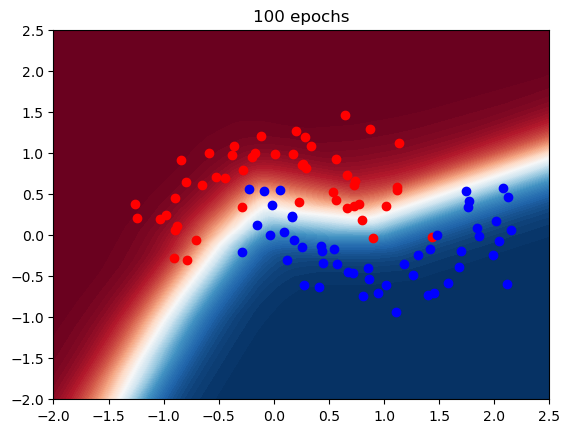

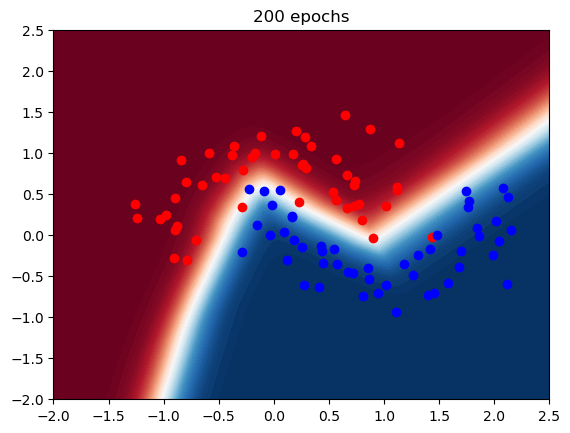

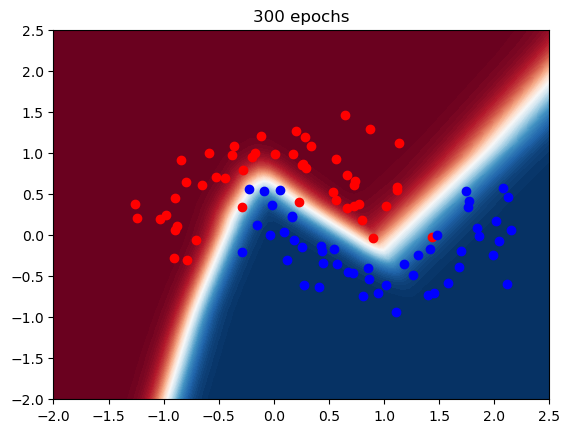

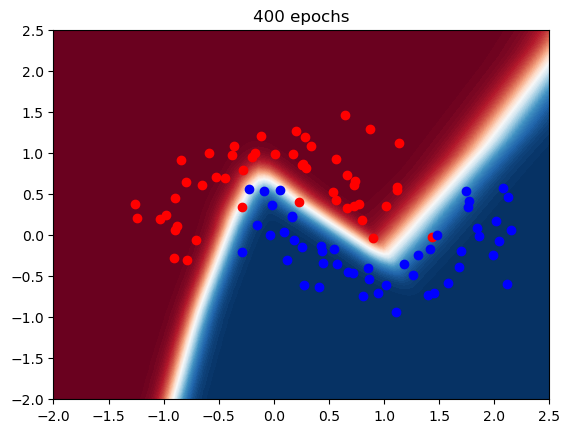

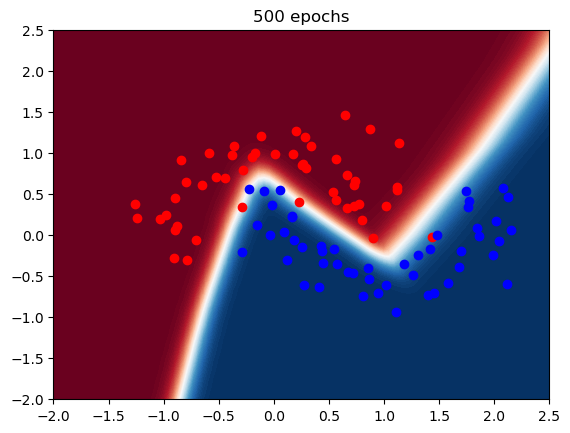

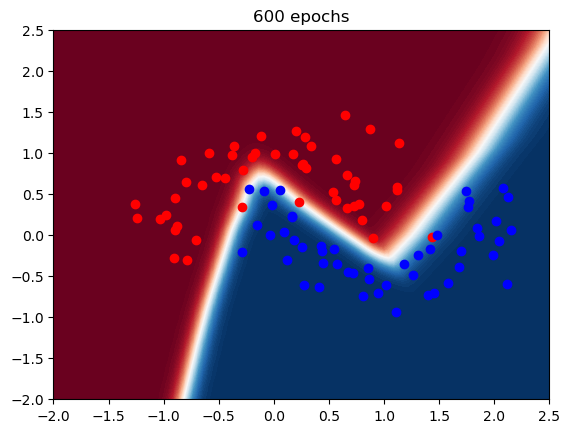

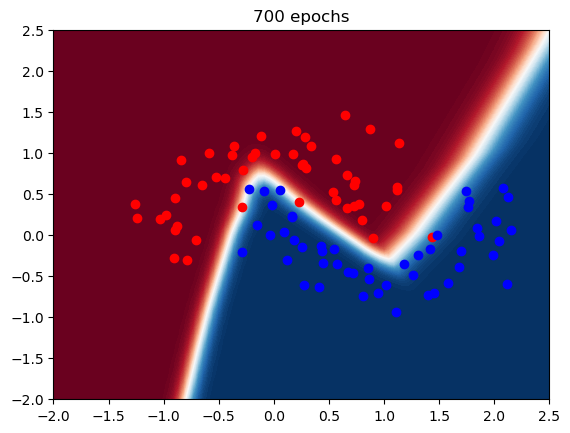

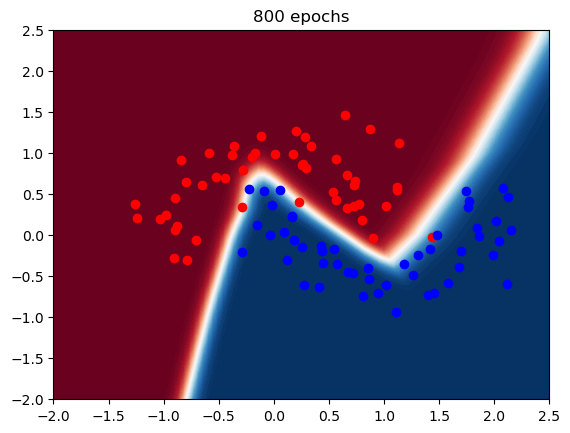

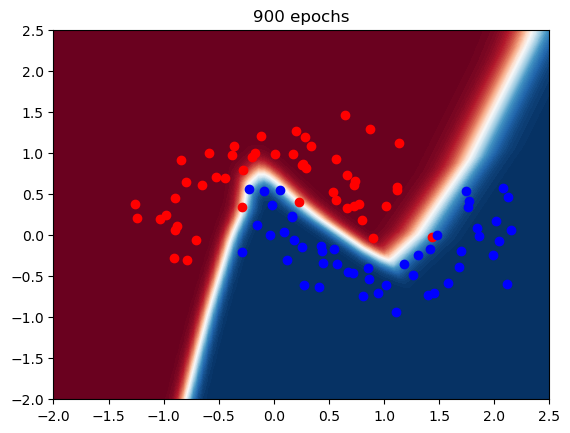

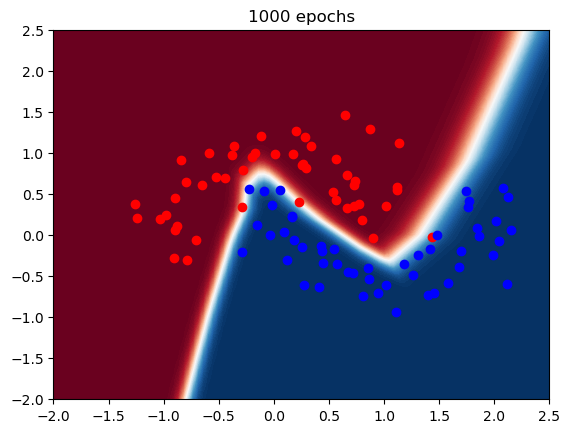

In [38]:
#model with manual optimizer and backpropagation
w1 = (2 * torch.rand(2, neurons) - 1) * 1 / np.sqrt(2)
w2 = (2 * torch.rand(neurons, 1) - 1) * 1 / np.sqrt(neurons)
b1 = (2 * torch.rand(neurons) - 1) * 1 / np.sqrt(2)
b2 = (2 * torch.rand(1) - 1) * 1 / np.sqrt(neurons)

# training loop
lr = 1
history_backprop = []
for i in range(1000):
    # forward
    z1 = X @ w1 + b1
    a1 = torch.relu(z1)
    z2 = a1 @ w2 + b2
    z2 = z2.squeeze(1)
    a2 = z2.sigmoid()
    loss = -torch.mean(y * torch.log(a2) + (1 - y) * torch.log(1 - a2))
    
    history_backprop.append(loss.item())

    # backward
    da2 = -1 / len(a2) * (y / a2 - (1 - y) / (1 - a2))
    dz2 = da2 * a2 * (1 - a2)
    dw2 = torch.transpose(a1, 0, 1) @ dz2.unsqueeze(1)
    da1 = dz2.unsqueeze(1) @ w2.T
    db2 = dz2.sum(0)
    dz1 = (z1 > 0) * da1
    dw1 = X.T @ dz1
    db1 = dz1.sum(0)

    # gradient update
    for par, grad in [(w1, dw1), (b1, db1), (w2, dw2), (b2, db2)]:
        par.add_(-lr * grad)
        
    #plot
    if (i+1) in range(0,1001,100):
        with torch.no_grad():
            visualize_classifier(
                lambda x: torch.sigmoid(torch.relu(torch.tensor(x, dtype=torch.float32) @ w1 + b1) @ w2 + b2),
                -2, 2.5, -2, 2.5, cmap="RdBu"
            )
        plt.scatter(*X[y==0].T, color="red")
        plt.scatter(*X[y==1].T, color="blue")
        plt.title(str(i+1) + " epochs")
        plt.show()

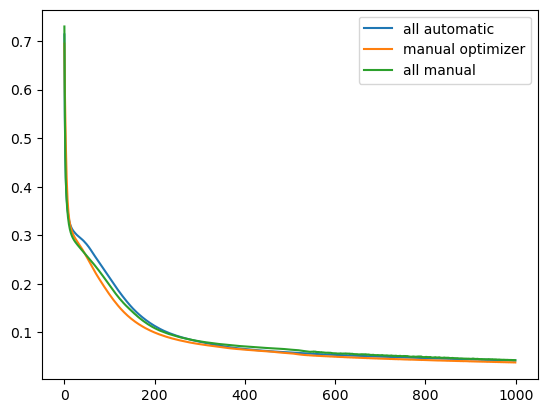

In [26]:
plt.plot(history_auto, label="all automatic")
plt.plot(history_opt, label="manual optimizer")
plt.plot(history_backprop, label="all manual")
plt.legend()